In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine,pearson
from surprise import accuracy

In [2]:
#Caricamento dataset
song_df_1 = pd.read_csv('triplets_file.csv')
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

song_df_2 =  pd.read_csv('song_data.csv')
song_df_2.drop_duplicates(['song_id'], inplace=True)

#Unione dataset
df_songs = pd.merge(song_df_1, song_df_2, on="song_id", how="left")

In [3]:
# Numero canzoni ascoltate da ogni utente
user_counts = df_songs.groupby('user_id')['song_id'].count()

# Utenti che hanno ascoltato almeno 30 canzoni
user_ten_id = user_counts[user_counts > 30].index.to_list()

In [4]:
# Numero di utenti che hanno ascoltato ogni canzone
song_counts = df_songs.groupby('song_id')['user_id'].count()

# Canzoni ascoltate da almeno 500 utenti
song_ten_id = song_counts[song_counts > 500].index.to_list()

In [5]:
df_songs_ridotto = df_songs[(df_songs['user_id'].isin(user_ten_id)) & (df_songs['song_id'].isin(song_ten_id))].reset_index(drop=True)
df_songs_ridotto

,user_id,song_id,listen_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,Paper Gangsta,The Fame Monster,Lady GaGa,2008
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,Sehr kosmisch,Musik von Harmonia,Harmonia,0
...,...,...,...,...,...,...,...
336425,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOHZPIK12A58A7CCAE,4,Te Amo,Rated R,Rihanna,2009
336426,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOIDDNJ12AC9071B90,1,That Should Be Me,My Worlds,Justin Bieber,2010
336427,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOIOESO12A6D4F621D,4,Unwell (Album Version),More Than You Think You Are,matchbox twenty,2003
336428,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007


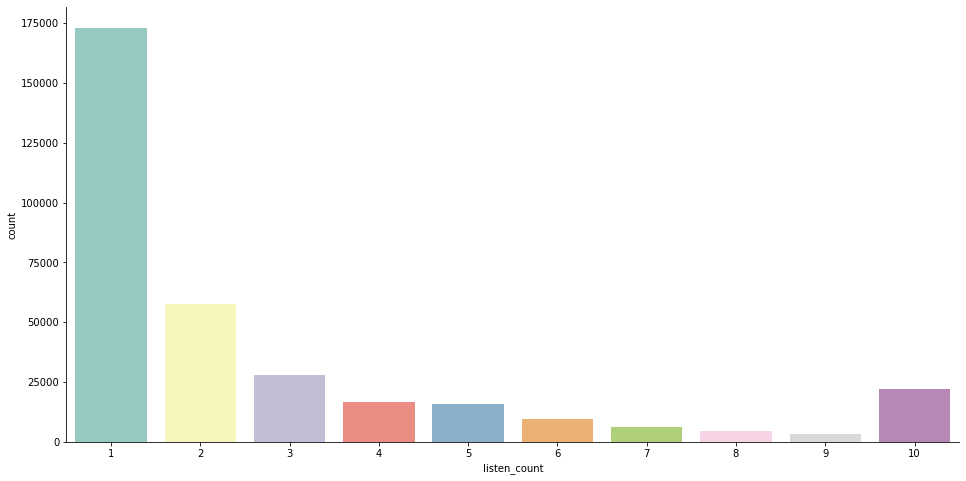

In [6]:
# Creazione scala valutazione

scala = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2214]

df_songs_ridotto ['listen_count'] = pd.cut(df_songs_ridotto ['listen_count'], bins=scala, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

listen_counts = pd.DataFrame(df_songs_ridotto .groupby('listen_count').size(), columns=['count']).reset_index(drop=False)

plt.figure(figsize=(16, 8))
sns.barplot(x='listen_count', y='count', palette='Set3', data=listen_counts)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [7]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_songs_ridotto [['user_id', 'title', 'listen_count']], reader)

In [8]:
train_set, test_set = train_test_split(data, test_size=.25)

In [9]:
# Funzione get top n predictions di Surprise
from collections import defaultdict
def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        top_n[uid].append((iid, est, r_ui))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        # print(user_ratings)
        user_ratings = sorted(user_ratings,key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

                                    KNN BASIC

In [10]:
# Definizione indice similarità
sim_cos = {'name':'cosine', 'user_based':False}

In [11]:
# Addestramento del modello
Kbasic = knns.KNNBasic(sim_options=sim_cos)
Kbasic.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [12]:
# Test del modello
predictions = Kbasic.test(test_set)

In [13]:
# Metriche di valutazione
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 2.3661
MAE:  1.6468


In [14]:
# Generazione top n previsioni
top_pred_knn = get_top_n(predictions,10)

In [15]:
top_pred_knn_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_pred_knn.items() for pair in row],columns=["userId" ,"title","rat_pred"])
top_pred_knn_df

,userId,title,rat_pred
0,a498a85e2bb584cf048a48c46e67d438e23c7f1b,Rock Star,1.496840
1,a498a85e2bb584cf048a48c46e67d438e23c7f1b,I Gotta Feeling,1.466856
2,a498a85e2bb584cf048a48c46e67d438e23c7f1b,Party In The U.S.A.,1.459479
3,a498a85e2bb584cf048a48c46e67d438e23c7f1b,Crazy,1.448266
4,a498a85e2bb584cf048a48c46e67d438e23c7f1b,You Belong With Me,1.432317
...,...,...,...
73418,7865594dd4c61c79de54002d588fef1e037b8c04,Fast As I Can,1.188729
73419,113d1ee9fc61aa94e506f6eba3c6d96cb98a3505,Taylor,2.653007
73420,7e3286eab0adeca89f300c4642eee6a1be176e34,Savior,2.689551
73421,16954c8b534325abadf5aca57594d3b7779ea3b9,Lithium,2.235221


In [16]:
top_pred_knn_df.loc[top_pred_knn_df['userId'] == 'b048f21afd5e7467f187bf9f9d413e97c32313a9', ('title', 'rat_pred')]

,title,rat_pred
69139,Speed Of Sound,5.444970
69140,In My Place,5.368005
69141,Fix You,5.294225
69142,Sparks,5.285498
69143,Lost!,5.231800
69144,Back Against The Wall,5.093979
69145,The District Sleeps Alone Tonight (Album),5.072608
69146,Human,5.015479
69147,If We Ever Meet Again,4.877969
69148,Drops Of Jupiter,4.816314


                                KNN MEANS MODEL

In [17]:
# Addestramento del modello 
KNNMeans = knns.KNNWithMeans(sim_options=sim_cos)
KNNMeans.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [18]:
# Test del modello
predictions_mean = KNNMeans.test(test_set)

In [19]:
# Metriche di valutazione
rmse = accuracy.rmse(predictions_mean)
mae = accuracy.mae(predictions_mean)

RMSE: 2.2970
MAE:  1.5997


In [20]:
# Generazione top n previsioni
top_pred_mean = get_top_n(predictions_mean,10)

In [21]:
top_pred_mean['b048f21afd5e7467f187bf9f9d413e97c32313a9']

[('Lost!', 5.50100015981436, 8.0),
 ('If We Ever Meet Again', 5.467767203234221, 1.0),
 ('Fix You', 5.346892299116302, 7.0),
 ('Speed Of Sound', 5.287948250316397, 5.0),
 ('In My Place', 5.193530912643535, 5.0),
 ('Human', 5.117289065036615, 6.0),
 ('Back Against The Wall', 5.046856138152913, 1.0),
 ('Sparks', 4.99783772244645, 4.0),
 ('The District Sleeps Alone Tonight (Album)', 4.933840258789533, 1.0),
 ('Drops Of Jupiter', 4.925922702211263, 4.0)]

In [22]:
top_pred_mean_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_pred_mean.items() for pair in row],columns=["userId" ,"title","rat_pred"])

top_pred_mean_df.loc[top_pred_mean_df['userId'] == 'b048f21afd5e7467f187bf9f9d413e97c32313a9', ('title', 'rat_pred')]

,title,rat_pred
69139,Lost!,5.501000
69140,If We Ever Meet Again,5.467767
69141,Fix You,5.346892
69142,Speed Of Sound,5.287948
69143,In My Place,5.193531
69144,Human,5.117289
69145,Back Against The Wall,5.046856
69146,Sparks,4.997838
69147,The District Sleeps Alone Tonight (Album),4.933840
69148,Drops Of Jupiter,4.925923


                            KNN Z SCORE MODEL

In [23]:
# Addestramento del modello
KNN_Z = knns.KNNWithZScore(sim_options=sim_cos)
KNN_Z.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [24]:
# Test del modello
predictions_Z = KNN_Z.test(test_set)

In [25]:
# Metriche di valutazione
rmse = accuracy.rmse(predictions_Z)
mae = accuracy.mae(predictions_Z)

RMSE: 2.3056
MAE:  1.5901


In [26]:
# Generazione top n previsioni
top_pred_Z = get_top_n(predictions_Z,10)

In [27]:
top_pred_Z_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_pred_Z.items() for pair in row],columns=["userId" ,"title","rat_pred"])

top_pred_Z_df.loc[top_pred_Z_df['userId'] == 'b048f21afd5e7467f187bf9f9d413e97c32313a9', ('title', 'rat_pred')]


,title,rat_pred
69139,If We Ever Meet Again,6.137865
69140,Lost!,5.900008
69141,Fix You,5.343006
69142,Human,5.318386
69143,Speed Of Sound,5.205422
69144,Back Against The Wall,5.068369
69145,Drops Of Jupiter,5.028949
69146,In My Place,4.958524
69147,The District Sleeps Alone Tonight (Album),4.872372
69148,Sparks,4.653699


                                USER BASED

                                BASIC KNN

In [28]:
# Definizione indice similarità
sim_pearson = {'name':'pearson', 'user_based':True}

In [ ]:
# Addestramento del modello
KNN_basic_u = knns.KNNBasic(sim_options=sim_pearson)
KNN_basic_u.fit(train_set)

In [ ]:
# Test del modello
predictions_basic_u = KNN_basic_u.test(test_set)

In [ ]:
# Metriche di valutazione
rmse = accuracy.rmse(predictions_basic_u)
mae = accuracy.mae(predictions_basic_u)

In [ ]:
# Generazione top n previsioni
top_pred_basic_u = get_top_n(predictions_basic_u,10)

In [ ]:
top_pred_basic_u_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_pred_basic_u.items() for pair in row],columns=["userId" ,"title","rat_pred"])

top_pred_basic_u_df.loc[top_pred_basic_u_df['userId'] == 'b048f21afd5e7467f187bf9f9d413e97c32313a9', ('title', 'rat_pred')]

                                                      
                                                      WITH MEANS

In [ ]:
# Addestramento del modello 
KNNMeans_u = knns.KNNWithMeans(sim_options=sim_pearson)
KNNMeans_u.fit(train_set)

In [ ]:
# Test del modello
predictions_mean_u = KNNMeans_u.test(test_set)

In [ ]:
# Metriche di valutazione
rmse = accuracy.rmse(predictions_mean_u)
mae = accuracy.mae(predictions_mean_u)

In [ ]:
# Generazione top n previsioni
top_pred_mean_u = get_top_n(predictions_mean_u,10)

In [ ]:
top_pred_mean_u_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_pred_mean_u.items() for pair in row],columns=["userId" ,"title","rat_pred"])

top_pred_mean_u_df.loc[ top_pred_mean_u_df['userId'] == 'b048f21afd5e7467f187bf9f9d413e97c32313a9', ('title', 'rat_pred')]

                                                    Z SCORE KNN

In [ ]:
# Addestramento del modello
KNN_Z_u = knns.KNNWithZScore(sim_options=sim_pearson)
KNN_Z_u.fit(train_set)

In [ ]:
# Test del modello
predictions_Z_u = KNN_Z_u.test(test_set)

In [ ]:
# Metriche di valutazione
rmse = accuracy.rmse(predictions_Z_u)
mae = accuracy.mae(predictions_Z_u)

In [ ]:
# Generazione top n previsioni
top_pred_Z_u = get_top_n(predictions_Z_u,10)

In [ ]:
top_pred_Z_u_df = pd.DataFrame([(id, pair[0],pair[1]) for id, row in top_pred_Z_u.items() for pair in row],columns=["userId" ,"title","rat_pred"])

top_pred_Z_u_df.loc[top_pred_Z_u_df['userId'] == 'b048f21afd5e7467f187bf9f9d413e97c32313a9', ('title', 'rat_pred')]

                                                           TABELLA CONFRONTO

In [ ]:
accuracy_tab = {'RMSE': [2.3775, 2.3138,  2.3251, 2.5794, 2.3704, 2.3645],
        'MAE': [ 1.6536, 1.6075,  1.5997, 1.9333, 1.6308, 1.6052]
        } 

accuracy_tab_df = pd.DataFrame(accuracy_tab, index=['Basic_I','WithMeans_I','Zscore_I','Basic_U','WithMeans_U','Zscore_U'])
display(accuracy_tab_df)

In [ ]:
accuracy_tab.to_csv('accuracy_tab.csv')